In [1]:
from lifelines import CoxPHFitter, plotting, KaplanMeierFitter
from lifelines.utils import k_fold_cross_validation, concordance_index
from lifelines.calibration import survival_probability_calibration
from lifelines.datasets import load_rossi
from lifelines.statistics import logrank_test, pairwise_logrank_test
import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
from tableone import TableOne

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#505050'
plt.rcParams['axes.labelcolor']= '#505050'
plt.rcParams['xtick.color'] = '#505050'
plt.rcParams['ytick.color'] = '#505050'
plt.rcParams['font.size']= 11

## Rossi dataset

In [3]:
# This data set is originally from Rossi et al. (1980), and is used as an example in Allison (1995). 
# The data pertain to 432 convicts who were released from Maryland state prisons in the 1970s and who were 
# followed up for one year after release. Half the released convicts were assigned at random to an experimental 
# treatment in which they were given financial aid; half did not receive aid.
#
# The following variables are included in the data:
#
# week: week of first arrest after release, or censoring time.
# arrest: the event indicator, equal to 1 for those arrested during the period of the study and 0 for those who were not arrested.
# fin: a factor, equal to 1 if the individual received financial aid after release from prison, and 0 if he did not; financial aid was a randomly assigned factor manipulated by the researchers.
# age: in years at the time of release.
# race: a factor, equal to 1 if black and 0 if other.
# wexp: a factor, equal to 1 if the individual had full-time work experience prior to incarceration and equalt to 0 if he did not.
# mar: a factor, equal to 1 if the individual was married at the time of release and 0 if he was not.
# paro: a factor, equal to 1 if the individual was released on parole and 0 if he was not.
# prio: number of prior convictions.
#
# PS: The principal purpose of the recidivism study was to assess the impact of financial aid on rearrest.

rossi_df = load_rossi()

In [4]:
rossi_df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


### Dataframe analysis

In [5]:
rossi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   week    432 non-null    int64
 1   arrest  432 non-null    int64
 2   fin     432 non-null    int64
 3   age     432 non-null    int64
 4   race    432 non-null    int64
 5   wexp    432 non-null    int64
 6   mar     432 non-null    int64
 7   paro    432 non-null    int64
 8   prio    432 non-null    int64
dtypes: int64(9)
memory usage: 30.5 KB


[]

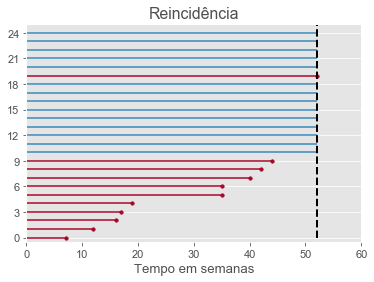

In [6]:
# Plotting only n individuals
df = rossi_df.sample(n=25, random_state=42)

durations = df.week.values
events = df.arrest.values

ax = plotting.plot_lifetimes(durations=durations, event_observed=events)
ax.set_xlim(0, 60)
ax.vlines(52, 0, 25, lw=2, linestyles='--')
ax.grid(axis='x')
ax.set_xlabel("Tempo em semanas")
ax.set_title("Reincidência")
plt.plot()

In [7]:
# Table One
columns = ["arrest", "fin", "wexp", "mar", "paro"]
groupby = ['race']
nonnormal = ["age"]

# create an instance of TableOne with the input arguments
grouped_table = TableOne(rossi_df, columns=columns, groupby=groupby, 
                         nonnormal=nonnormal, missing=False,
                         dip_test=True, normal_test=True, tukey_test=True)

# view tableone
grouped_table

/Users/bruna/miniconda3/envs/fairness-health/lib/python3.7/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),


Grouped by race                       
                        Overall          0           1
n                           432         53         379
arrest, n (%) 0      318 (73.6)  41 (77.4)  277 (73.1)
              1      114 (26.4)  12 (22.6)  102 (26.9)
fin, n (%)    0      216 (50.0)  31 (58.5)  185 (48.8)
              1      216 (50.0)  22 (41.5)  194 (51.2)
wexp, n (%)   0      185 (42.8)  20 (37.7)  165 (43.5)
              1      247 (57.2)  33 (62.3)  214 (56.5)
mar, n (%)    0      379 (87.7)  44 (83.0)  335 (88.4)
              1       53 (12.3)   9 (17.0)   44 (11.6)
paro, n (%)   0      165 (38.2)  23 (43.4)  142 (37.5)
              1      267 (61.8)  30 (56.6)  237 (62.5)

Text(0.5, 1.0, 'Distribuição de idade')

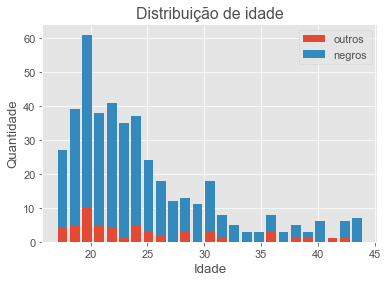

In [8]:
# age distribution
ax = rossi_df.pivot(columns='race').age.plot(kind = 'hist', stacked=True, bins=25, rwidth=0.8)
ax.legend(labels=['outros', 'negros'])
plt.xlabel('Idade')
plt.ylabel('Quantidade')
plt.title('Distribuição de idade')

Text(0.5, 1.0, 'Distribuição de prisões anteriores')

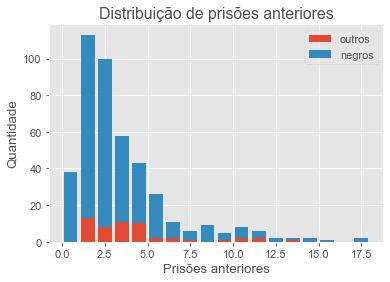

In [9]:
# prior arrest distribution
ax = rossi_df.pivot(columns='race').prio.plot(kind = 'hist', stacked=True, bins=18, rwidth=0.8)
ax.legend(labels=['outros', 'negros'])
plt.xlabel('Prisões anteriores')
plt.ylabel('Quantidade')
plt.title('Distribuição de prisões anteriores')

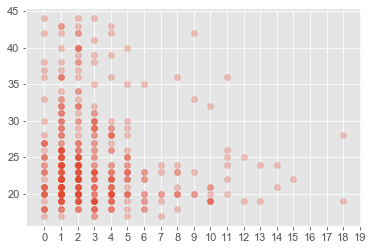

In [10]:
# Prior arrests by age
x = rossi_df["prio"]
y = rossi_df["age"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, 20, 1)
ax.set_xticks(major_ticks)
plt.scatter(x, y, alpha=0.3)

### Model

#### Kaplan Meier

In [11]:
T = rossi_df["week"]
E = rossi_df["arrest"]

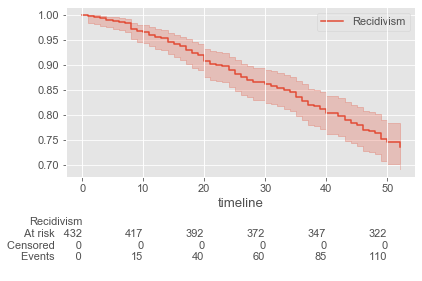

In [12]:
kmf = KaplanMeierFitter().fit(T, E, label="Recidivism")
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()

#### Cox

In [13]:
rossi_df = rossi_df.drop('age', axis=1)

In [14]:
cph = CoxPHFitter()
# formula="fin + mar + prio + paro + wexp + race + fin*mar + fin*prio + fin*paro + fin*wexp + fin*race + mar*prio + mar*paro + mar*wexp + mar*race + prio*paro + prio*wexp + prio*race + paro*wexp + paro*race + wexp*race"
# cph.fit(rossi_df, duration_col='week', event_col='arrest', formula=formula)
cph.fit(rossi_df, duration_col='week', event_col='arrest')

/Users/bruna/miniconda3/envs/fairness-health/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

In [15]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -662.74
         time fit was run = 2021-08-31 10:48:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.42       0.66       0.19            -0.79            -0.05                 0.45                 0.95
race        0.28       1.32       0.31            -0.33             0.88                 0.72                 2.41
wexp       -0.35       0.71       0.20            -0.75             0.05                 0.47                 1.05
mar        -0.55       0.58       0.38            -1.29             0.20                 0.27                 1.22
paro       -0.02       0.98       0.19            -0.40             0.36                 0.67                 1.43
prio        0.09       1.09       0.03             0.03             0.14                 1.03                 1.16

              z      p   -log2(p)
covariate                        
fin       -2.20   0.03       5.17
race       0.90   0.37       1.44
wexp      -1.71   0.09       3.52
mar       -1.45   0.15       2.75
paro      -0.10   0.92       0.12
prio       3.14 <0.005       9.19
---
Concordance = 0.63
Partial AIC = 1337.48
log-likelihood ratio test = 25.28 on 6 df
-log2(p) of ll-ratio test = 11.69

In [16]:
cph.check_assumptions(rossi_df)

Proportional hazard assumption looks okay.


/Users/bruna/miniconda3/envs/fairness-health/lib/python3.7/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


[]

In [17]:
scores = k_fold_cross_validation(cph, rossi_df, duration_col='week', event_col='arrest', k=10, scoring_method="concordance_index")
print(np.mean(scores))

0.5982792893752574


In [18]:
# cph.print_summary()

### Covariates

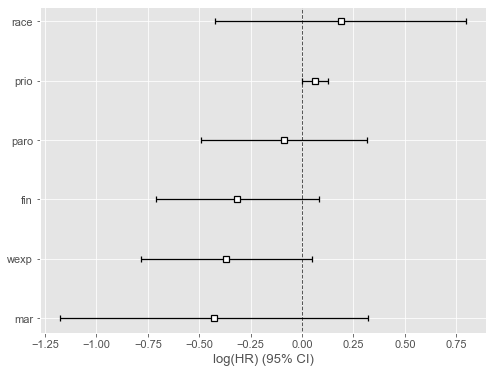

In [19]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])

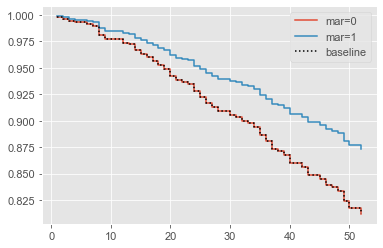

In [20]:
cph.plot_partial_effects_on_outcome('mar', values=np.arange(0, 2, 1))

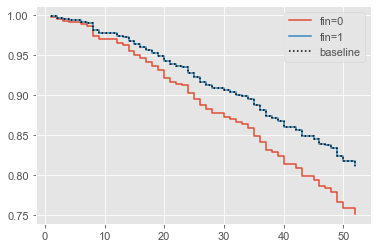

In [21]:
cph.plot_partial_effects_on_outcome('fin', values=np.arange(0, 2, 1))

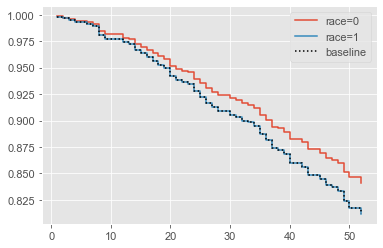

In [22]:
cph.plot_partial_effects_on_outcome('race', values=np.arange(0, 2, 1))

## Fairness

Survival rates (S(t)) simply gives us the probability that event will not occur beyond time t, in this case, rearrest.

In [23]:
def survival_curve_plot(surv1, surv2, label1, label2):

    df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2 = survival_curve_median_calc(surv1, surv2)

    # Compute stats: tests whether 2 samples are drawn from the same distribution
    # H0: samples are drawn from the same distribution
    # H1: samples are not drawn from the same distribution
    
    # If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis 
    # that the distributions of the two samples are the same.
    test = compute_stats(df_surv_median1, df_surv_median2)

    # Plot curves 
    ax = plt.subplots(figsize=(8, 6))
    
    # 95% Confidence interval
    ci1_left = surv1.quantile(0.025, axis=1)
    ci1_right = surv1.quantile(0.975, axis=1)
    ci2_left = surv2.quantile(0.025, axis=1)
    ci2_right = surv2.quantile(0.975, axis=1)
    
    ax = df_surv_median1.plot(label=label1, color='turquoise', linestyle='--')
    ax.fill_between(df_surv_median1.index, ci1_left, ci1_right, alpha=0.2, facecolor='turquoise')

    ax.plot(df_surv_median2, label=label2, color='slateblue', linestyle='-.')
    ax.fill_between(df_surv_median2.index, ci2_left, ci2_right, alpha=0.2, facecolor='slateblue')

    plt.text(0.2, 0.2, str(test), fontsize=8, transform=plt.gcf().transFigure)
    plt.legend(loc="upper right")
    plt.ylabel('S(t | z)')
    plt.xlabel('Tempo')

In [24]:
def survival_curve_median_calc(surv1, surv2):
    # Median and standard deviation
    df_surv_median1 = surv1.median(axis=1)
    df_surv_std1 = surv1.std(axis=1)
    df_surv_median2 = surv2.median(axis=1)
    df_surv_std2 = surv2.std(axis=1)

    return df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2

In [25]:
def compute_stats(rvs1, rvs2):
    test_stat = stats.ks_2samp(rvs1, rvs2)
    return test_stat

### Group Fairness

In [26]:
def km(dataset_list_a, dataset_list_b, label_a, label_b):

    kmf = KaplanMeierFitter()

    kmf.fit(dataset_list_a['week'], dataset_list_a['arrest'], label=label_a)
    ax = kmf.plot_survival_function()
    kmf.fit(dataset_list_b['week'], dataset_list_b['arrest'], label=label_b)
    ax = kmf.plot_survival_function(ax=ax)

    ax.set_ylabel('S(t|z)')
    ax.set_xlabel('Tempo')

In [27]:
def logrank(df1, df2):
    results = logrank_test(df1.week, df2.week, event_observed_A=df1.arrest, event_observed_B=df2.arrest)
    return print("stats: " + str(results.test_statistic) + " p-value: " + str(results.p_value))

In [28]:
df_black = rossi_df.loc[rossi_df["race"] == 1]
df_other = rossi_df.loc[rossi_df["race"] == 0]
label1= "negros"
label2= "outros"

df_fin = rossi_df.loc[rossi_df["fin"] == 1]
df_not_fin = rossi_df.loc[rossi_df["fin"] == 0]
label3= "financiados"
label4= "não financiados"

df_mar = rossi_df.loc[rossi_df["mar"] == 1]
df_not_mar = rossi_df.loc[rossi_df["mar"] == 0]
label5= "casados"
label6= "não casados"

In [29]:
logrank(df_black, df_other)

stats: 0.5761017136839002 p-value: 0.44784439425217526


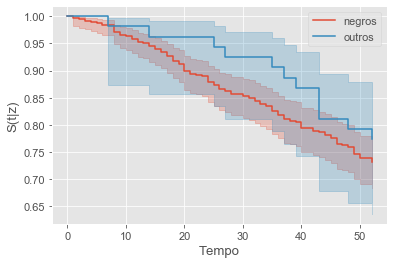

In [30]:
km(df_black, df_other, "negros", "outros")

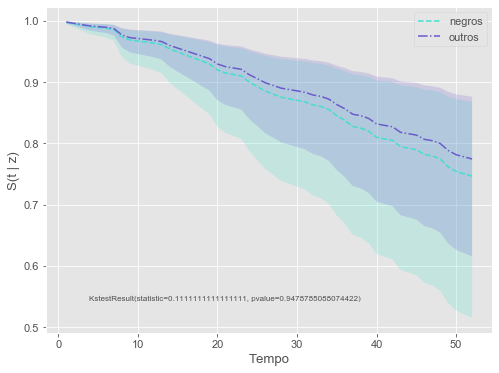

In [31]:
# Race
surv_black = cph.predict_survival_function(df_black)
surv_other = cph.predict_survival_function(df_other)
survival_curve_plot(surv_black, surv_other, label1, label2)

In [32]:
logrank(df_fin, df_not_fin)

stats: 3.837569576549051 p-value: 0.05011611740900573


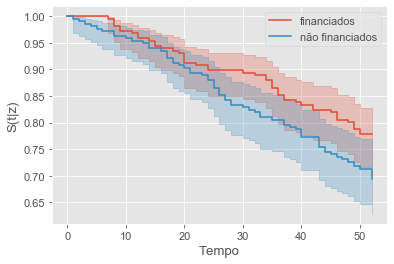

In [33]:
km(df_fin, df_not_fin, "financiados", "não financiados")

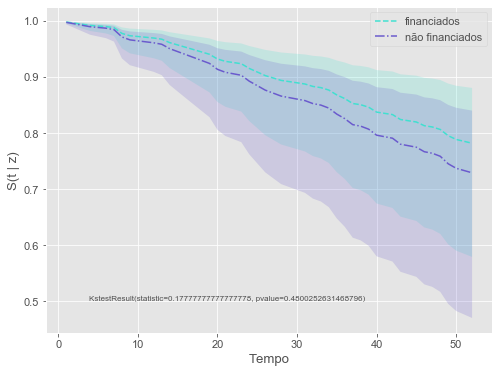

In [34]:
# Received financial aid **
surv_fin = cph.predict_survival_function(df_fin)
surv_not_fin = cph.predict_survival_function(df_not_fin)
survival_curve_plot(surv_fin, surv_not_fin, label3, label4)

In [35]:
logrank(df_mar, df_not_mar)

stats: 3.937435589204879 p-value: 0.04722271221809162


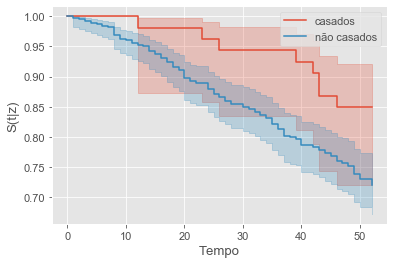

In [36]:
km(df_mar, df_not_mar, "casados", "não casados")

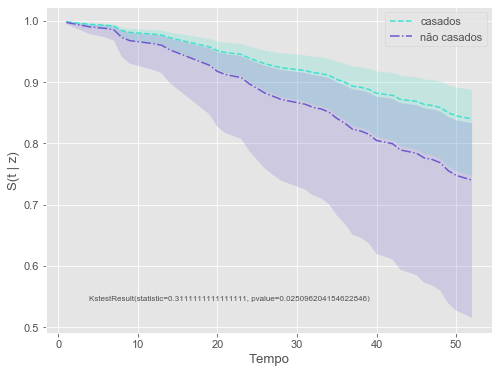

In [37]:
# Married ***
surv_mar = cph.predict_survival_function(df_mar)
surv_not_mar = cph.predict_survival_function(df_not_mar)
survival_curve_plot(surv_mar, surv_not_mar, label5, label6)

In [38]:
df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2 = survival_curve_median_calc(surv_mar, surv_not_mar)

In [47]:
df = df_surv_median1.to_frame().reset_index()

In [49]:
df

,index,0
0,1.0,0.998560
1,2.0,0.997117
2,3.0,0.995673
3,4.0,0.994226
4,6.0,0.992778
5,7.0,0.991324
6,8.0,0.984073
7,9.0,0.981142
8,12.0,0.978207
9,13.0,0.976738


### Conditional statistical parity

In [38]:
df1 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 1)]
df5 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 1)]

label1= "negros | casados, financiados"
label5= "outros | casados, financiados"

df2 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]
df6 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]

label2= "negros | casados, não financiados"
label6= "outros | casados, não financiados"

df3 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]
df7 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]

label3= "negros | não casados, financiados"
label7= "outros | não casados, financiados"

df4 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]
df8 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]

label4= "negros | não casados, não financiados"
label8= "outros | não casados, não financiados"

In [39]:
logrank(df1, df5)

stats: 0.4507390239479458 p-value: 0.5019842124694144


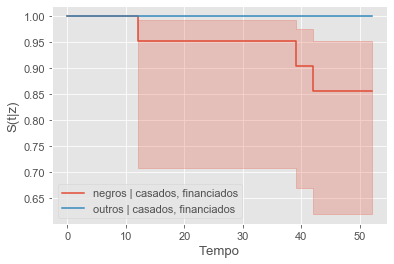

In [40]:
km(df1, df5, label1, label5)

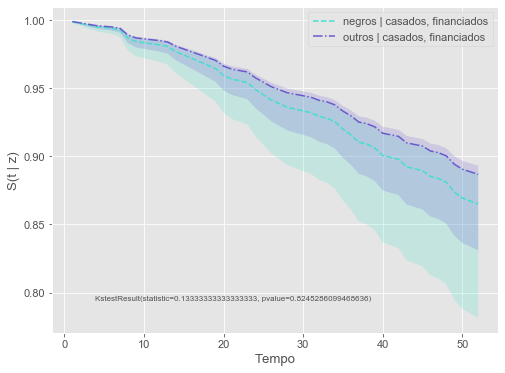

In [41]:
# Black, married, received or not financial aid
surv1 = cph.predict_survival_function(df1)
surv5 = cph.predict_survival_function(df5)
survival_curve_plot(surv1, surv5, label1, label5)

In [42]:
logrank(df2, df6)

stats: 0.005221446477926764 p-value: 0.9423953333917686


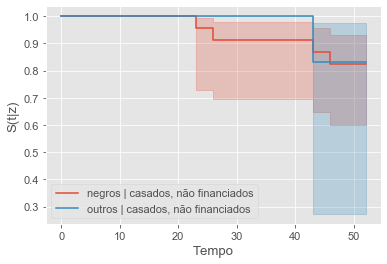

In [43]:
km(df2, df6, label2, label6)

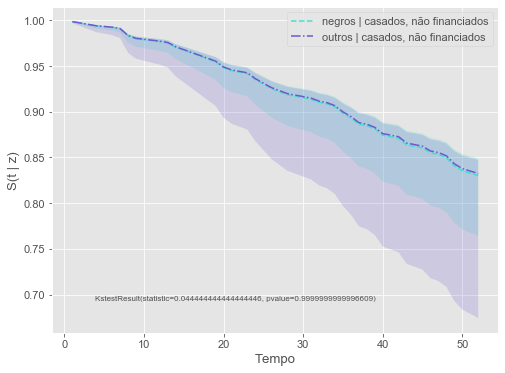

In [44]:
# Black, not married, received or not financial aid **
surv2 = cph.predict_survival_function(df2)
surv6 = cph.predict_survival_function(df6)
survival_curve_plot(surv2, surv6, label2, label6)

In [45]:
logrank(df3, df7)

stats: 0.0773435524733638 p-value: 0.780930154750807


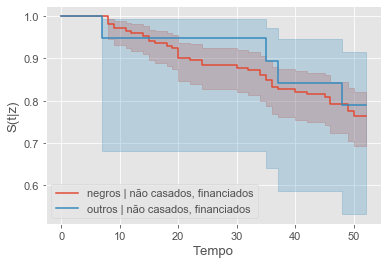

In [46]:
km(df3, df7, label3, label7)

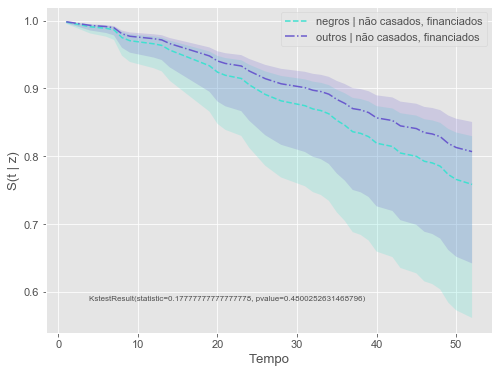

In [47]:
# Other, married, received or not financial aid ****
surv3 = cph.predict_survival_function(df3)
surv7 = cph.predict_survival_function(df7)
survival_curve_plot(surv3, surv7, label3, label7)

In [48]:
logrank(df4, df8)

stats: 0.40857578146728235 p-value: 0.5226932689476944


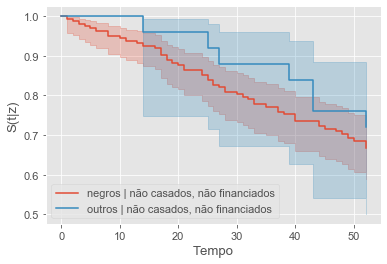

In [49]:
km(df4, df8, label4, label8)

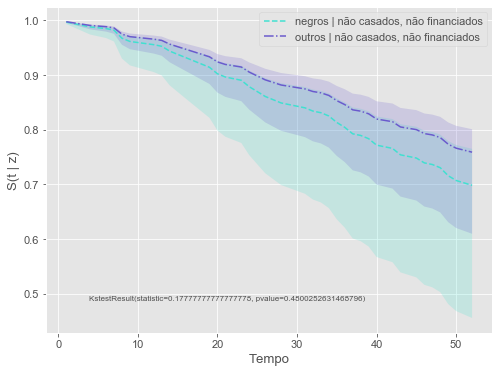

In [50]:
# Other, not married, received or not financial aid ****
surv4 = cph.predict_survival_function(df4)
surv8 = cph.predict_survival_function(df8)
survival_curve_plot(surv4, surv8, label4, label8)

### Modified C-Index

In [51]:
from pycox.evaluation import EvalSurv

/Users/bruna/miniconda3/envs/fairness-health/lib/python3.7/site-packages/numba/types/__init__.py:110: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  long_ = _make_signed(np.long)
/Users/bruna/miniconda3/envs/fairness-health/lib/python3.7/site-packages/numba/types/__init__.py:111: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long

In [52]:
# pycox time dependent c-index
surv = cph.predict_survival_function(rossi_df)
ev = EvalSurv(surv, rossi_df["week"].to_numpy(), rossi_df["arrest"].to_numpy())
pycox_cindex = ev.concordance_td()
print(pycox_cindex)
print(cph.concordance_index_)

0.6290157909066159
0.612784363985902


In [53]:
def evaluate_modified_cindex(durations_g1, durations_g2, events_g1, events_g2, surv_g1, surv_g2):
    ev_g1 = EvalSurv(surv_g1, durations_g1, events_g1)
    ev_g2 = EvalSurv(surv_g2, durations_g2, events_g2)

    # c-index
    cindex_g1 = ev_g1.concordance_td()
    cindex_g2 = ev_g2.concordance_td()

    # modified c-index
    cindex_modified_g1 = ev_g1.concordance_td_modified_for_groups(durations_g2, events_g2, surv_g2)
    cindex_modified_g2 = ev_g2.concordance_td_modified_for_groups(durations_g1, events_g1, surv_g1)

    cindex_modified_g1_time_event = ev_g1.concordance_td_modified_for_groups_time_event(durations_g2, events_g2, surv_g2)
    cindex_modified_g2_time_event = ev_g2.concordance_td_modified_for_groups_time_event(durations_g1, events_g1, surv_g1)

    return cindex_g1, cindex_g2, cindex_modified_g1, cindex_modified_g2, cindex_modified_g1_time_event, cindex_modified_g2_time_event


In [54]:
# Race
cindex_black, cindex_other, cindex_modified_black_other, cindex_modified_other_black, cindex_modified_black_other_time_event, cindex_modified_other_black_time_event = evaluate_modified_cindex(df_black["week"].to_numpy(), df_other["week"].to_numpy(), df_black["arrest"].to_numpy(), df_other["arrest"].to_numpy(), surv_black, surv_other)

print(cindex_black, cindex_other) 
print(cindex_modified_black_other[0]/cindex_modified_black_other[1], cindex_modified_black_other)
print(cindex_modified_other_black[0]/cindex_modified_other_black[1], cindex_modified_other_black)
print(cindex_modified_black_other_time_event[0]/cindex_modified_black_other_time_event[1], cindex_modified_black_other_time_event)
print(cindex_modified_other_black_time_event[0]/cindex_modified_other_black_time_event[1], cindex_modified_other_black_time_event)


0.6228404952658412 0.6785714285714286
0.22993886129155522 (1203.5, 5234.0)
0.26015325670498085 (1018.5, 3915.0)
0.7700611387084448 (4030.5, 5234.0)
0.7398467432950192 (2896.5, 3915.0)


In [55]:
# Financial Aid
cindex_fin, cindex_not_fin, cindex_modified_fin, cindex_modified_not_fin, cindex_modified_fin_not_fin_time_event, cindex_modified_not_fin_fin_time_event = evaluate_modified_cindex(df_fin["week"].to_numpy(), df_not_fin["week"].to_numpy(), df_fin["arrest"].to_numpy(), df_not_fin["arrest"].to_numpy(), surv_fin, surv_not_fin)

print(cindex_fin, cindex_not_fin) 
print(cindex_modified_fin[0]/cindex_modified_fin[1], cindex_modified_fin)
print(cindex_modified_not_fin[0]/cindex_modified_not_fin[1], cindex_modified_not_fin)
print(cindex_modified_fin_not_fin_time_event[0]/cindex_modified_fin_not_fin_time_event[1], cindex_modified_fin_not_fin_time_event)
print(cindex_modified_not_fin_fin_time_event[0]/cindex_modified_not_fin_fin_time_event[1], cindex_modified_not_fin_fin_time_event)


0.5909879622600586 0.6365141955835962
0.1338644997889405 (1268.5, 9476.0)
0.29210961493030946 (3709.5, 12699.0)
0.8661355002110596 (8207.5, 9476.0)
0.7078903850696905 (8989.5, 12699.0)


In [56]:
# Married
cindex_mar, cindex_not_mar, cindex_modified_mar, cindex_modified_not_mar, cindex_modified_mar_not_mar_time_event, cindex_modified_not_mar_mar_time_event = evaluate_modified_cindex(df_mar["week"].to_numpy(), df_not_mar["week"].to_numpy(), df_mar["arrest"].to_numpy(), df_not_mar["arrest"].to_numpy(), surv_mar, surv_not_mar)

print(cindex_fin, cindex_not_fin) 
print(cindex_modified_fin[0]/cindex_modified_fin[1], cindex_modified_fin)
print(cindex_modified_not_fin[0]/cindex_modified_not_fin[1], cindex_modified_not_fin)
print(cindex_modified_fin_not_fin_time_event[0]/cindex_modified_fin_not_fin_time_event[1], cindex_modified_fin_not_fin_time_event)
print(cindex_modified_not_fin_fin_time_event[0]/cindex_modified_not_fin_fin_time_event[1], cindex_modified_not_fin_fin_time_event)


0.5909879622600586 0.6365141955835962
0.1338644997889405 (1268.5, 9476.0)
0.29210961493030946 (3709.5, 12699.0)
0.8661355002110596 (8207.5, 9476.0)
0.7078903850696905 (8989.5, 12699.0)


In [57]:
# Race and financial aid
df_black_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["fin"] == 1)]
df_other_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["fin"] == 1)]

surv_black_fin = cph.predict_survival_function(df_black_fin)
surv_other_fin = cph.predict_survival_function(df_other_fin)

cindex_black_fin, cindex_other_fin, cindex_modified_black_fin, cindex_modified_other_fin, cindex_modified_black_fin_time_event, cindex_modified_other_fin_time_event = evaluate_modified_cindex(df_black_fin["week"].to_numpy(), df_other_fin["week"].to_numpy(), df_black_fin["arrest"].to_numpy(), df_other_fin["arrest"].to_numpy(), surv_black_fin, surv_other_fin)

print(cindex_black_fin, cindex_other_fin) 
print(cindex_modified_black_fin[0]/cindex_modified_black_fin[1], cindex_modified_black_fin)
print(cindex_modified_other_fin[0]/cindex_modified_other_fin[1], cindex_modified_other_fin)
print(cindex_modified_black_fin_time_event[0]/cindex_modified_black_fin_time_event[1], cindex_modified_black_fin_time_event)
print(cindex_modified_other_fin_time_event[0]/cindex_modified_other_fin_time_event[1], cindex_modified_other_fin_time_event)


0.572107765451664 0.7628205128205128
0.22778402699662542 (202.5, 889.0)
0.22947214076246333 (156.5, 682.0)
0.7722159730033745 (686.5, 889.0)
0.7705278592375366 (525.5, 682.0)


In [58]:
# Race and no financial aid
df_black_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["fin"] == 0)]
df_other_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["fin"] == 0)]

surv_black_not_fin = cph.predict_survival_function(df_black_not_fin)
surv_other_not_fin = cph.predict_survival_function(df_other_not_fin)

cindex_black_not_fin, cindex_other_not_fin, cindex_modified_black_not_fin, cindex_modified_other_not_fin, cindex_modified_black_not_fin_time_event, cindex_modified_other_not_fin_time_event = evaluate_modified_cindex(df_black_not_fin["week"].to_numpy(), df_other_not_fin["week"].to_numpy(), df_black_not_fin["arrest"].to_numpy(), df_other_not_fin["arrest"].to_numpy(), surv_black_not_fin, surv_other_not_fin)

print(cindex_black_not_fin, cindex_other_not_fin) 
print(cindex_modified_black_not_fin[0]/cindex_modified_black_not_fin[1], cindex_modified_black_not_fin)
print(cindex_modified_other_not_fin[0]/cindex_modified_other_not_fin[1], cindex_modified_other_not_fin)
print(cindex_modified_black_not_fin_time_event[0]/cindex_modified_black_not_fin_time_event[1], cindex_modified_black_not_fin_time_event)
print(cindex_modified_other_not_fin_time_event[0]/cindex_modified_other_not_fin_time_event[1], cindex_modified_other_not_fin_time_event)


0.6359583952451708 0.6218487394957983
0.21311475409836064 (377.0, 1769.0)
0.2214228617106315 (277.0, 1251.0)
0.7868852459016393 (1392.0, 1769.0)
0.7785771382893685 (974.0, 1251.0)


In [59]:
# race, married and no financial aid
df_black_married_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]
df_other_married_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]

surv_black_married_not_fin = cph.predict_survival_function(df_black_married_not_fin)
surv_other_married_not_fin = cph.predict_survival_function(df_other_married_not_fin)

cindex_black_married_not_fin, cindex_other_married_not_fin, cindex_modified_black_married_not_fin, cindex_modified_other_married_not_fin, cindex_modified_black_married_not_fin_time_event, cindex_modified_other_married_not_fin_time_event = evaluate_modified_cindex(df_black_married_not_fin["week"].to_numpy(), df_other_married_not_fin["week"].to_numpy(), df_black_married_not_fin["arrest"].to_numpy(), df_other_married_not_fin["arrest"].to_numpy(), surv_black_married_not_fin, surv_other_married_not_fin)

print(cindex_black_married_not_fin, cindex_other_married_not_fin) 
print(cindex_modified_black_married_not_fin[0]/cindex_modified_black_married_not_fin[1], cindex_modified_black_married_not_fin)
print(cindex_modified_other_married_not_fin[0]/cindex_modified_other_married_not_fin[1], cindex_modified_other_married_not_fin)
print(cindex_modified_black_married_not_fin_time_event[0]/cindex_modified_black_married_not_fin_time_event[1], cindex_modified_black_married_not_fin_time_event)
print(cindex_modified_other_married_not_fin_time_event[0]/cindex_modified_other_married_not_fin_time_event[1], cindex_modified_other_married_not_fin_time_event)


0.7073170731707317 1.0
0.2391304347826087 (5.5, 23.0)
0.9761904761904762 (20.5, 21.0)
0.7608695652173914 (17.5, 23.0)
0.023809523809523808 (0.5, 21.0)


In [60]:
# race, not married and financial aid
df_black_not_married_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]
df_other_not_married_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]

surv_black_not_married_fin = cph.predict_survival_function(df_black_not_married_fin)
surv_other_not_married_fin = cph.predict_survival_function(df_other_not_married_fin)

cindex_black_not_married_fin, cindex_other_not_married_fin, cindex_modified_black_not_married_fin, cindex_modified_other_not_married_fin, cindex_modified_black_not_married_fin_time_event, cindex_modified_other_not_married_fin_time_event = evaluate_modified_cindex(df_black_not_married_fin["week"].to_numpy(), df_other_not_married_fin["week"].to_numpy(), df_black_not_married_fin["arrest"].to_numpy(), df_other_not_married_fin["arrest"].to_numpy(), surv_black_not_married_fin, surv_other_not_married_fin)

print(cindex_black_not_married_fin, cindex_other_not_married_fin) 
print(cindex_modified_black_not_married_fin[0]/cindex_modified_black_not_married_fin[1], cindex_modified_black_not_married_fin)
print(cindex_modified_other_not_married_fin[0]/cindex_modified_other_not_married_fin[1], cindex_modified_other_not_married_fin)
print(cindex_modified_black_not_married_fin_time_event[0]/cindex_modified_black_not_married_fin_time_event[1], cindex_modified_black_not_married_fin_time_event)
print(cindex_modified_other_not_married_fin_time_event[0]/cindex_modified_other_not_married_fin_time_event[1], cindex_modified_other_not_married_fin_time_event)


0.5543478260869565 0.7196969696969697
0.2043847241867044 (144.5, 707.0)
0.18490878938640132 (111.5, 603.0)
0.7956152758132956 (562.5, 707.0)
0.8150912106135987 (491.5, 603.0)


In [61]:
# race, not married and no financial aid
df_black_not_married_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]
df_other_not_married_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]

surv_black_not_married_not_fin = cph.predict_survival_function(df_black_not_married_not_fin)
surv_other_not_married_not_fin = cph.predict_survival_function(df_other_not_married_not_fin)

cindex_black_not_married_not_fin, cindex_other_not_married_not_fin, cindex_modified_black_not_married_not_fin, cindex_modified_other_not_married_not_fin, cindex_modified_black_not_married_not_fin_time_event, cindex_modified_other_not_married_not_fin_time_event = evaluate_modified_cindex(df_black_not_married_not_fin["week"].to_numpy(), df_other_not_married_not_fin["week"].to_numpy(), df_black_not_married_not_fin["arrest"].to_numpy(), df_other_not_married_not_fin["arrest"].to_numpy(), surv_black_not_married_not_fin, surv_other_not_married_not_fin)

print(cindex_black_not_married_not_fin, cindex_other_not_married_not_fin) 
print(cindex_modified_black_not_married_not_fin[0]/cindex_modified_black_not_married_not_fin[1], cindex_modified_black_not_married_not_fin)
print(cindex_modified_other_not_married_not_fin[0]/cindex_modified_other_not_married_not_fin[1], cindex_modified_other_not_married_not_fin)
print(cindex_modified_black_not_married_not_fin_time_event[0]/cindex_modified_black_not_married_not_fin_time_event[1], cindex_modified_black_not_married_not_fin_time_event)
print(cindex_modified_other_not_married_not_fin_time_event[0]/cindex_modified_other_not_married_not_fin_time_event[1], cindex_modified_other_not_married_not_fin_time_event)


0.6150913632180885 0.5240963855421686
0.17822155237377543 (236.5, 1327.0)
0.1060126582278481 (100.5, 948.0)
0.8217784476262245 (1090.5, 1327.0)
0.8939873417721519 (847.5, 948.0)
